In [1]:
pip install pandas unicode matplotlib seaborn scikit-learn plotly scipy 

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
pd.set_option("mode.copy_on_write", True)

# 1. Preparation for Isolation Forest

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


combined_df = pd.read_csv('../data/output/consumo_datamart_silver_sectorecon_ohe.csv')
features_to_scale= ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
X = combined_df[features_to_scale]
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit_transform(X_scaled)

labels = kmeans.labels_

combined_df['Cluster'] = labels

combined_df.head()

output_filepath = '../data/output/consumo_datamart_gold.csv'
combined_df.to_csv(output_filepath, index=False)

c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# 2. Calibration of Contamination Factor

In [4]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import IsolationForest

def silhouette_scorer(estimator, X, y=None):
    preds = estimator.fit_predict(X)
    unique_labels = np.unique(preds)
    if len(unique_labels) > 1:
        score = silhouette_score(X, preds);
        return score
    else:
        print("Unique labels:", unique_labels)  
        return -1  

combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
data = combined_df[final_features].copy()
# Create Isolation Forest 
iso_forest = IsolationForest(random_state=42)
param_grid = {
    'contamination': [ 0.05, 0.1, 0.25,  0.4, 0.5 ],  # Proportion of outliers 
}
# Create RandomizedSearch  
random_search = RandomizedSearchCV(iso_forest, param_distributions=param_grid,
                                   scoring=silhouette_scorer, cv=3, random_state=42)
# Run random search
random_search.fit(data[features]) 

print("Best parameters:", random_search.best_params_)
print("Best silhouette score: {:.2f}".format(random_search.best_score_))




c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'contamination': 0.05}
Best silhouette score: 0.32


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

def get_anomalies(df, contamination=0.05):
    df= df.copy()
       
    
    # Indices are preserved after the split
    X = df
    y = df.index  
    
    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and fit the Isolation Forest on the training data
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    iso_forest.fit(X_train)

    # Predict anomalies on the training and testing data
    train_preds = iso_forest.predict(X_train)
    test_preds = iso_forest.predict(X_test)
    
    # Score anomalies on the training and testing 
    train_score = iso_forest.decision_function(X_train)
    test_score = iso_forest.decision_function(X_test)
        
    # Calculate the percentage of anomalies detected in the training set
    anomaly_count_train = (train_preds == -1).sum()  # Count the number of -1s in the predictions
    total_train = len(train_preds)  # Total number of training data points
    anomaly_percentage_train = (anomaly_count_train / total_train) * 100  # Calculate the percentage
    print(f"Percentage of anomalies detected in the training data: {anomaly_percentage_train:.3f}%")

    # Calculate the percentage of anomalies detected in the testing set
    anomaly_count_test = (test_preds == -1).sum()  # Count the number of -1s in the predictions
    total_test = len(test_preds)  # Total number of training data points
    anomaly_percentage_test = (anomaly_count_test / total_test) * 100  # Calculate the percentage
    print(f"Percentage of anomalies detected in the test data: {anomaly_percentage_test:.3f}%")

    #  Predictions are added  back to the original DataFrame using the original indices
    df.loc[y_train, 'Anomaly'] = train_preds
    df.loc[y_train, 'Anomaly_Score'] = train_score
    
    df.loc[y_test, 'Anomaly'] = test_preds
    df.loc[y_test, 'Anomaly_Score'] = test_score
    
       
    return df



# 3. Calculation of outliers/anomaly scores and Robustness in the global unidimensional perspective

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df['Anomaly']= pd.NA
combined_df['Anomaly_Score_Global']= pd.NA
data = combined_df[final_features]
data[final_features + ['Anomaly', 'Anomaly_Score_Global']]= get_anomalies(data)
combined_df.update(data[['Anomaly','Anomaly_Score_Global']])


anomaly_percentage = combined_df[combined_df['Anomaly'] == -1].shape[0] / combined_df.shape[0] * 100
print(f"Percentage of anomalies detected: {anomaly_percentage:.3f}%")

combined_df.rename(columns={'Anomaly':'Anomaly_Global'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)


Percentage of anomalies detected in the training data: 5.000%
Percentage of anomalies detected in the test data: 4.943%
Percentage of anomalies detected: 4.989%


In [5]:

# Group by 'ClienteId' and calculate the percentage of anomalies
anomaly_percentage_global = combined_df.groupby('ClienteId')['Anomaly_Global'].apply(
    lambda x: (x == -1.0).sum()*100/len(combined_df)
).reset_index(name='Porc_sospechosos_global')

anomaly_percentage_global

,ClienteId,Porc_sospechosos_global
0,1,0.004100
1,2,0.106382
2,3,0.062146
3,4,0.036036
4,5,2.047796
5,6,0.067972
6,7,0.390786
7,8,0.193559
8,9,0.298430
9,10,0.591466


# 4 Recalibration of Contamination Factor per client

In [31]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import IsolationForest

def silhouette_scorer(estimator, X, y=None):
    preds = estimator.fit_predict(X)
    unique_labels = np.unique(preds)
    if len(unique_labels) > 1:
        score = silhouette_score(X, preds)
        return score
    else:
        print("Unique labels:", unique_labels)  
        return -1  

combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features = ['Dia_Sin', 'Dia_Cos', 'Hora_Sin', 'Hora_Cos', 'Mes_Sin', 'Mes_Cos']
final_features = features + time_features
clients = sorted(list(combined_df['ClienteId'].unique()))

# Create a DataFrame to store results
results_df = pd.DataFrame(columns=['ClienteId', 'Best Parameters', 'Best Silhouette Score'])

for idclient in clients:
    data = combined_df[combined_df['ClienteId'] == idclient].copy()

    # Create Isolation Forest 
    iso_forest = IsolationForest(random_state=42)

    param_grid = {
        'contamination': [0.05, 0.1, 0.25, 0.4, 0.5],  
    }

    # Create RandomizedSearch object
    random_search = RandomizedSearchCV(iso_forest, param_distributions=param_grid,n_iter=5,
                                       scoring=silhouette_scorer, cv=3, random_state=42)
    # Perform random search
    random_search.fit(data[features])

    # Collecting the best parameters and the best score for each client
    new_row = pd.DataFrame({
        'ClienteId': [idclient],
        'Best Parameters': [random_search.best_params_],
        'Best Silhouette Score': ["{:.2f}".format(random_search.best_score_)]
    })

   
    results_df = pd.concat([results_df, new_row], ignore_index=True)

print(results_df)


   ClienteId          Best Parameters Best Silhouette Score
0          1   {'contamination': 0.1}                  0.36
1          2   {'contamination': 0.1}                  0.31
2          3   {'contamination': 0.1}                  0.30
3          4   {'contamination': 0.1}                  0.35
4          5   {'contamination': 0.1}                  0.33
5          6  {'contamination': 0.25}                  0.16
6          7   {'contamination': 0.1}                  0.16
7          8   {'contamination': 0.1}                  0.20
8          9  {'contamination': 0.05}                  0.24
9         10  {'contamination': 0.25}                  0.21
10        11  {'contamination': 0.05}                  0.41
11        12  {'contamination': 0.05}                  0.30
12        13  {'contamination': 0.05}                  0.22
13        14  {'contamination': 0.05}                  0.36
14        15  {'contamination': 0.05}                  0.48
15        16  {'contamination': 0.05}   

In [32]:
results_df.to_csv('../data/output/contamination_factor_client_isoforest.csv', index=False)

# 4.1 Calculation of outliers/anomaly scores and Robustness in the Client perspective

In [41]:


contamination_df = pd.read_csv('../data/output/contamination_factor_client_isoforest.csv')

results = []
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df['Anomaly_Score_Cliente'] = pd.NA
combined_df['Anomaly'] = pd.NA

clients = sorted(list(combined_df['ClienteId'].unique()))
for idclient in sorted(clients):
    data = combined_df[combined_df['ClienteId'] == idclient]
    data =data[final_features]
    dictionary = eval(contamination_df[contamination_df['ClienteId'] == idclient]['Best Parameters'].iloc[0])
    data[final_features + ['Anomaly','Anomaly_Score_Cliente' ]]=get_anomalies(data, 
                                                                              contamination=dictionary['contamination'])
    combined_df.update(data[['Anomaly','Anomaly_Score_Cliente']])
    anomalies_data = data[data['Anomaly'] == -1]
    # Calculate the percentage of anomalies detected
    anomaly_percentage_by_client = anomalies_data.shape[0]/data.shape[0]
   
    
    results.append((idclient,  anomaly_percentage_by_client * 100, 
                    combined_df[combined_df['ClienteId'] == idclient]['Sector_Economico'].iloc[0] ))
anomaly_percentages_by_client = pd.DataFrame(results, 
                                      columns=['ClienteId', 
                                               'Porc_sospechosos_cliente',
                                               'Sector_Economico'])

anomaly_percentages_by_client.sort_values(by='Porc_sospechosos_cliente', ascending=False)


combined_df.rename(columns={'Anomaly':'Anomaly_Cliente'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)
   

Percentage of anomalies detected in the training data: 10.004%
Percentage of anomalies detected in the test data: 9.423%
Percentage of anomalies detected in the training data: 10.004%
Percentage of anomalies detected in the test data: 9.703%
Percentage of anomalies detected in the training data: 10.004%
Percentage of anomalies detected in the test data: 9.677%
Percentage of anomalies detected in the training data: 10.004%
Percentage of anomalies detected in the test data: 9.119%
Percentage of anomalies detected in the training data: 10.004%
Percentage of anomalies detected in the test data: 8.839%
Percentage of anomalies detected in the training data: 25.000%
Percentage of anomalies detected in the test data: 24.435%
Percentage of anomalies detected in the training data: 10.004%
Percentage of anomalies detected in the test data: 10.389%
Percentage of anomalies detected in the training data: 10.004%
Percentage of anomalies detected in the test data: 9.728%
Percentage of anomalies detect

# 5. Recalibration of contamination factor per sector

In [42]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import IsolationForest

def silhouette_scorer(estimator, X, y=None):
    preds = estimator.fit_predict(X)
    unique_labels = np.unique(preds)
    if len(unique_labels) > 1:
        score = silhouette_score(X, preds)
        return score
    else:
        print("Unique labels:", unique_labels)  
        return -1  

combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features = ['Dia_Sin', 'Dia_Cos', 'Hora_Sin', 'Hora_Cos', 'Mes_Sin', 'Mes_Cos']
final_features = features + time_features
sectors = sorted(list(combined_df['Sector_Economico'].unique()))


results_df = pd.DataFrame(columns=['ClienteId', 'Best Parameters', 'Best Silhouette Score'])

for sector in sectors:
    data = combined_df[combined_df['Sector_Economico'] == sector].copy()

    # Create Isolation Forest 
    iso_forest = IsolationForest(random_state=42)

    param_grid = {
        'contamination': [0.05, 0.1, 0.25, 0.4, 0.5],  
    }

    # Create RandomizedSearch 
    random_search = RandomizedSearchCV(iso_forest, param_distributions=param_grid,n_iter=5,
                                       scoring=silhouette_scorer, cv=3, random_state=42)
    # Perform random search
    random_search.fit(data[features])

    # Collecting the best parameters and the best score for each client
    new_row = pd.DataFrame({
        'sector': [sector],
        'Best Parameters': [random_search.best_params_],
        'Best Silhouette Score': ["{:.2f}".format(random_search.best_score_)]
    })

    # Append the results to the DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.to_csv('../data/output/contamination_factor_sector_isoforest.csv', index=False)

# Display the DataFrame after completing the search for all clients
print(results_df)


                                          ClienteId          Best Parameters  \
0           captacion_tratamiento_distribucion_agua   {'contamination': 0.1}   
1                   cultivo_arboles_frutales_nueces   {'contamination': 0.1}   
2            cultivo_frutos_nueces_arboles_arbustos  {'contamination': 0.25}   
3                                cultivo_hortalizas  {'contamination': 0.05}   
4      cultivo_hortalizas_melones_raices_tuberculos  {'contamination': 0.05}   
5  elaboracion_cacao_chocolate_productos_confiteria  {'contamination': 0.05}   
6         venta_mayor_metales_minerales_metaliferos  {'contamination': 0.05}   

  Best Silhouette Score  
0                  0.10  
1                  0.13  
2                  0.38  
3                  0.27  
4                  0.22  
5                  0.62  
6                  0.24  


# 5.1 Calculation of outliers/anomaly scores and Robustness from  the lens of economical sector

In [43]:
contamination_df = pd.read_csv('../data/output/contamination_factor_sector_isoforest.csv')
results = []
sectors = sorted(list(combined_df['Sector_Economico'].unique()))
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
combined_df['Anomaly_Score_Sector'] = pd.NA
combined_df['Anomaly'] = pd.NA
anomaly_percentage_sector_consolidado= pd.DataFrame()
for sector in sectors:
    data_orig = combined_df[combined_df['Sector_Economico'] == sector]
    data = data_orig[final_features]
    dictionary = eval(contamination_df[contamination_df['sector'] == sector]['Best Parameters'].iloc[0])
    data_orig[final_features + ['Anomaly','Anomaly_Score_Sector' ]]=get_anomalies(data, 
                                                                              contamination=dictionary['contamination'])
    combined_df.update(data_orig[['Anomaly','Anomaly_Score_Sector']])
    anomaly_percentage_sector = data_orig.groupby('ClienteId')['Anomaly'].apply(
        lambda x: (x == -1.0).sum()*100/len(data_orig)
    ).reset_index(name='Porc_sospechosos_sector')

    anomaly_percentage_sector_consolidado = pd.concat([anomaly_percentage_sector_consolidado, 
                                                       anomaly_percentage_sector], ignore_index=True)


combined_df.rename(columns={'Anomaly':'Anomaly_Sector'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)


Percentage of anomalies detected in the training data: 10.000%
Percentage of anomalies detected in the test data: 10.169%
Percentage of anomalies detected in the training data: 10.001%
Percentage of anomalies detected in the test data: 9.898%
Percentage of anomalies detected in the training data: 25.000%
Percentage of anomalies detected in the test data: 24.759%
Percentage of anomalies detected in the training data: 5.000%
Percentage of anomalies detected in the test data: 4.762%
Percentage of anomalies detected in the training data: 5.000%
Percentage of anomalies detected in the test data: 4.929%
Percentage of anomalies detected in the training data: 5.001%
Percentage of anomalies detected in the test data: 4.974%
Percentage of anomalies detected in the training data: 5.000%
Percentage of anomalies detected in the test data: 5.020%


# 6. Recalibration of the contamination factor in the Cluster perspective. We want to validate that the calibrated contamination factor is still valid per cluster

In [15]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import IsolationForest

def silhouette_scorer(estimator, X, y=None):
    preds = estimator.fit_predict(X)
    unique_labels = np.unique(preds)
    if len(unique_labels) > 1:
        score = silhouette_score(X, preds);
        return score
    else:
        print("Unique labels:", unique_labels)  
        return -1  


combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features

for cluster in range(0,4):
    data = combined_df[combined_df['Cluster']==cluster].copy()


    # Create Isolation Forest 
    iso_forest = IsolationForest(random_state=42)


    param_grid = {
        'contamination': [ 0.05, 0.1, 0.25,  0.4, 0.5 ],  
    }


    # Create RandomizedSearch  
    random_search = RandomizedSearchCV(iso_forest, param_distributions=param_grid,
                                    scoring=silhouette_scorer, cv=3, random_state=42)
    # Perform random search
    random_search.fit(data[features]) 

    print(f"Best parameters For Cluster {cluster}:", random_search.best_params_)
    print(f"Best silhouette score For Cluster {cluster}:", "{:.2f}".format(random_search.best_score_))




c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters For Cluster 0: {'contamination': 0.05}
Best silhouette score For Cluster 0: 0.43


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters For Cluster 1: {'contamination': 0.05}
Best silhouette score For Cluster 1: 0.41


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters For Cluster 2: {'contamination': 0.05}
Best silhouette score For Cluster 2: 0.41


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters For Cluster 3: {'contamination': 0.05}
Best silhouette score For Cluster 3: 0.27


# 7. Calculation of outliers/anomaly scores and Robustness from  the lens of the clusters

In [44]:
results = []
sectors = sorted(list(combined_df['Sector_Economico'].unique()))
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
combined_df['Anomaly_Score_Cluster'] = pd.NA
combined_df['Anomaly'] = pd.NA
clusters = sorted(list(combined_df['Cluster'].unique()))
anomaly_percentage_cluster_consolidado= pd.DataFrame()
for cluster in clusters:
    data_orig = combined_df[combined_df['Cluster'] == cluster]
    data = data_orig[final_features]
    data_orig[final_features + ['Anomaly','Anomaly_Score_Cluster']]=get_anomalies(data)
    combined_df.update(data_orig[['Anomaly','Anomaly_Score_Cluster']])
    anomaly_percentage_cluster = data_orig.groupby('ClienteId')['Anomaly'].apply(
        lambda x: (x == -1.0).sum()*100/len(data_orig)
    ).reset_index(name='Porc_sospechosos_cluster')
    anomaly_percentage_cluster['Cluster']=cluster
    
  
    # Concatenate DataFrames
    anomaly_percentage_cluster_consolidado = pd.concat([anomaly_percentage_cluster_consolidado, 
                                                       anomaly_percentage_cluster], ignore_index=True)
    
combined_df.rename(columns={'Anomaly':'Anomaly_Cluster'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)






Percentage of anomalies detected in the training data: 5.002%
Percentage of anomalies detected in the test data: 4.791%
Percentage of anomalies detected in the training data: 5.000%
Percentage of anomalies detected in the test data: 4.960%
Percentage of anomalies detected in the training data: 5.000%
Percentage of anomalies detected in the test data: 4.978%
Percentage of anomalies detected in the training data: 5.001%
Percentage of anomalies detected in the test data: 5.133%


In [46]:
merged_df = pd.merge(anomaly_percentage_global, 
                    anomaly_percentages_by_client, 
                     on='ClienteId', 
                     how='inner')
merged_df = pd.merge(merged_df, 
                    anomaly_percentage_sector_consolidado, 
                     on='ClienteId', 
                     how='inner')
merged_df = pd.merge(merged_df, 
                    anomaly_percentage_cluster_consolidado, 
                     on='ClienteId', 
                     how='inner')
merged_df.to_csv('../data/output/porcentaje_anomalias_consolidado.csv', index=False)


# 8. Example of Visualizations with PLotly Express

In [47]:
import pandas as pd
import plotly.express as px


anomaly_percentage = pd.read_csv('../data/output/porcentaje_anomalias_consolidado.csv')

# Sort the DataFrame first by 'Sector_Economico' and then by 'Porc_sospechosos_sector' in descending order
sorted_df = anomaly_percentage.sort_values(by=['Sector_Economico', 'Porc_sospechosos_sector'], ascending=[True, False])


unique_clients = sorted_df.drop_duplicates(subset=['Sector_Economico', 'ClienteId'])
top_unique_clients = unique_clients.groupby('Sector_Economico').head(5)


fig = px.bar(top_unique_clients, x='Porc_sospechosos_sector', y='Sector_Economico', orientation='h',
             color='Porc_sospechosos_sector', text='Porc_sospechosos_sector',
             title='Top 5 Unique Client Anomaly Percentages by Economic Sector',
             labels={'Porc_sospechosos_sector': 'Percentage of Anomalies', 'Sector_Economico': 'Economic Sector'},
             height=600, width=800, hover_data=['ClienteId'])


fig.update_layout(yaxis={'categoryorder':'total ascending'}, xaxis_title='Anomaly Percentage',
                  yaxis_title='Economic Sector', uniformtext_mode='hide', template='plotly_white')

fig.update_traces(hovertemplate="<b>%{y}</b><br>Percentage: %{x}<br>Client ID: %{customdata[0]}")


fig.show() 


In [48]:
import pandas as pd
import plotly.express as px


anomaly_percentage = pd.read_csv('../data/output/porcentaje_anomalias_consolidado.csv')

# Sort the DataFrame first by 'Cluster', 'Sector_Economico', and then by 'Porc_sospechosos_sector' in descending order
sorted_df = anomaly_percentage.sort_values(by=['Cluster', 'Sector_Economico', 'Porc_sospechosos_sector'], ascending=[True, True, False])


unique_clients = sorted_df.drop_duplicates(subset=['Cluster', 'Sector_Economico', 'ClienteId'])
top_unique_clients = unique_clients.groupby(['Cluster', 'Sector_Economico']).head(5)


fig = px.bar(top_unique_clients, x='Porc_sospechosos_sector', y='Sector_Economico', orientation='h',
             color='Cluster', text='Porc_sospechosos_sector',
             title='Top 5 Unique Client Anomaly Percentages by Economic Sector and Cluster',
             labels={'Porc_sospechosos_sector': 'Percentage of Anomalies', 'Sector_Economico': 'Economic Sector', 'Cluster': 'Cluster'},
             height=600, width=800, hover_data=['ClienteId'])

fig.update_layout(yaxis={'categoryorder':'total ascending'}, xaxis_title='Anomaly Percentage',
                  yaxis_title='Economic Sector', uniformtext_mode='hide', template='plotly_white')


fig.update_traces(hovertemplate="<b>%{y}</b><br>Cluster: %{marker.color}<br>Percentage: %{x}<br>Client ID: %{customdata[0]}")


fig.show()


# 9. Distribution of anomaly scores for each perspective

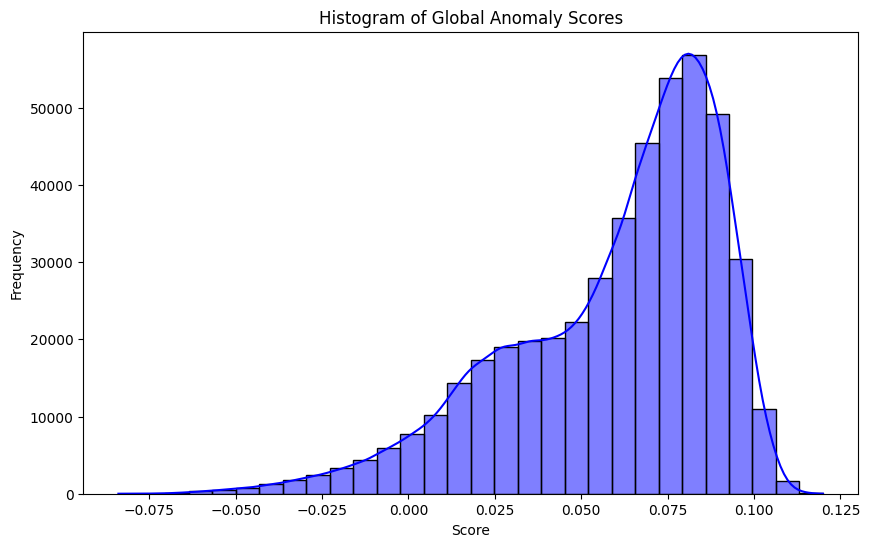

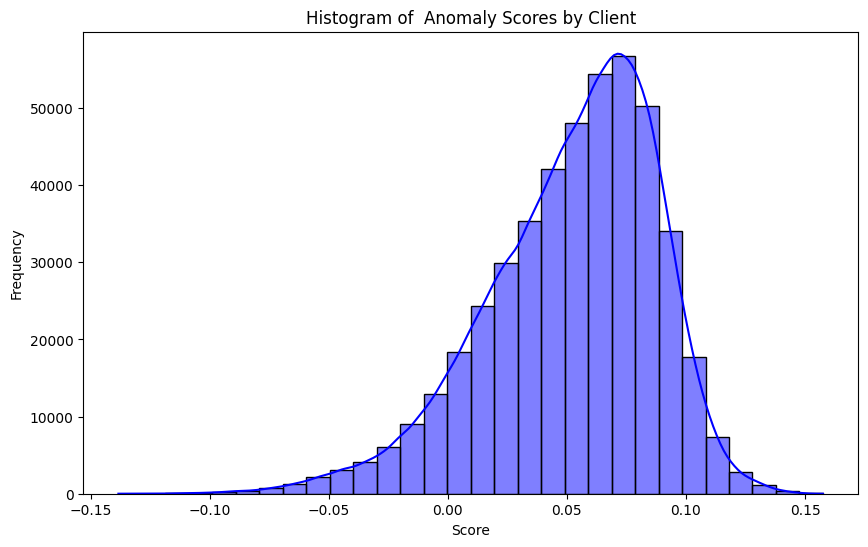

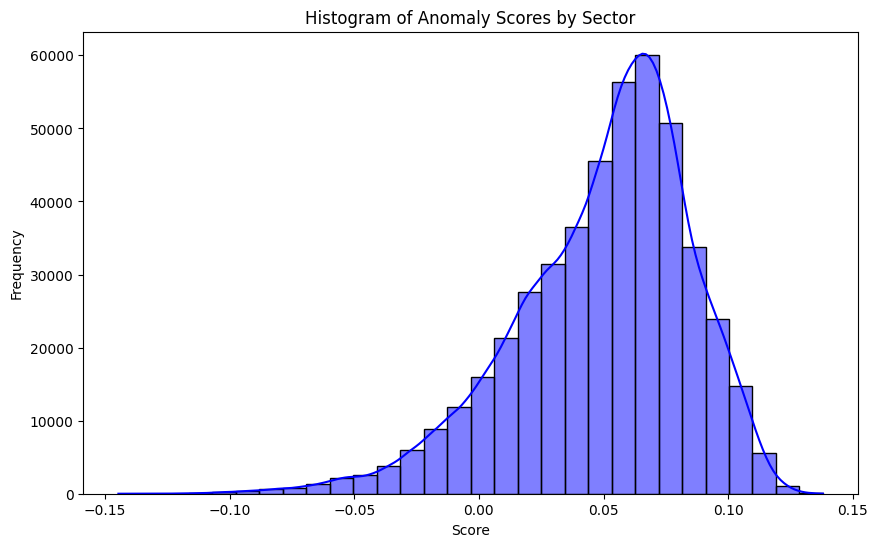

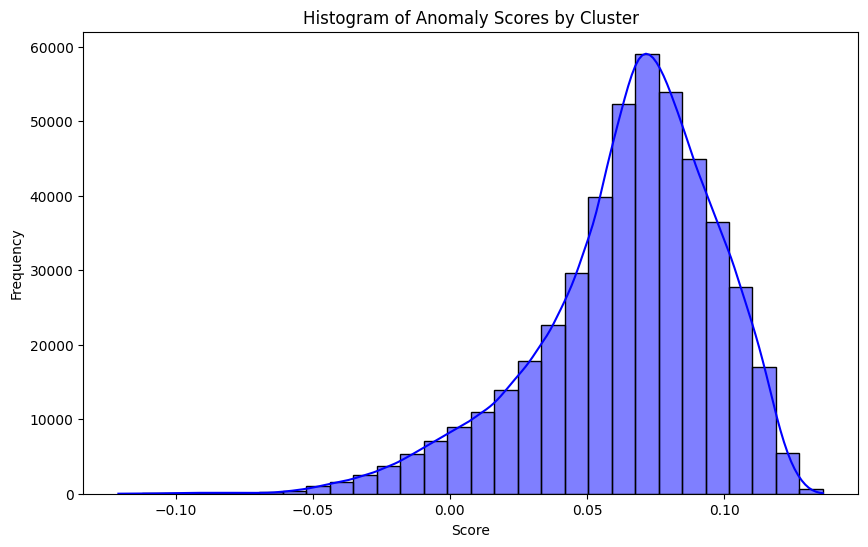

In [51]:

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd


combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')


# plot histograms
def plot_histogram(data, column, title, bins=30, color='blue'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=bins, kde=True, color=color)
    plt.title(title)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

# Plotting histograms 
plot_histogram(combined_df, 'Anomaly_Score_Global', 'Histogram of Global Anomaly Scores')
plot_histogram(combined_df, 'Anomaly_Score_Cliente', 'Histogram of  Anomaly Scores by Client')
plot_histogram(combined_df, 'Anomaly_Score_Sector', 'Histogram of Anomaly Scores by Sector')
plot_histogram(combined_df, 'Anomaly_Score_Cluster', 'Histogram of Anomaly Scores by Cluster')


# 10. Plot of outliers for  the four consumption variables

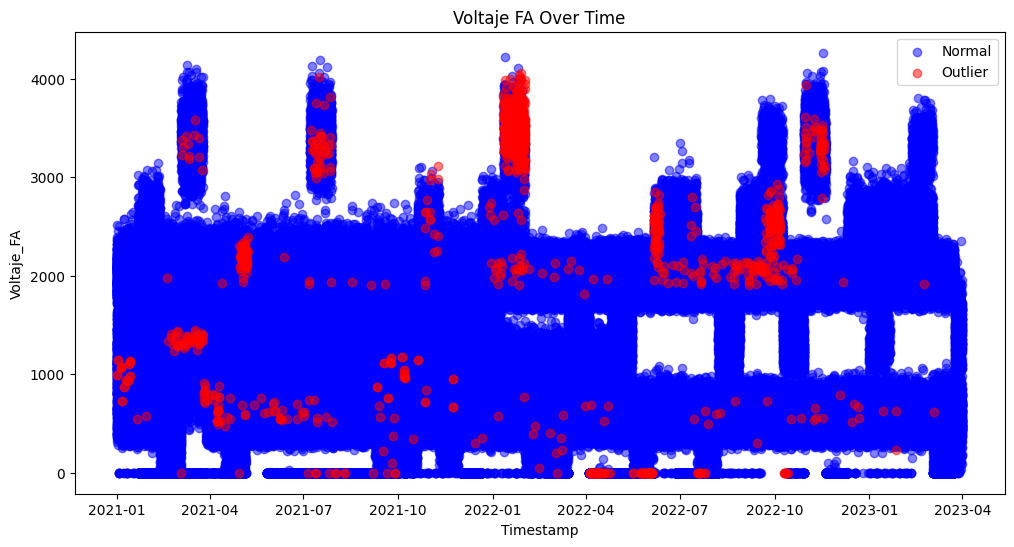

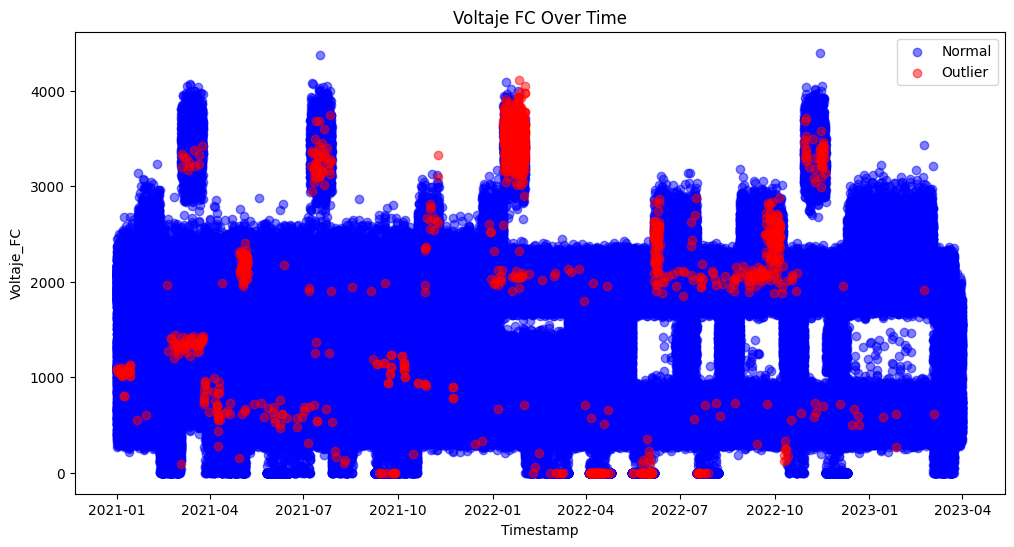

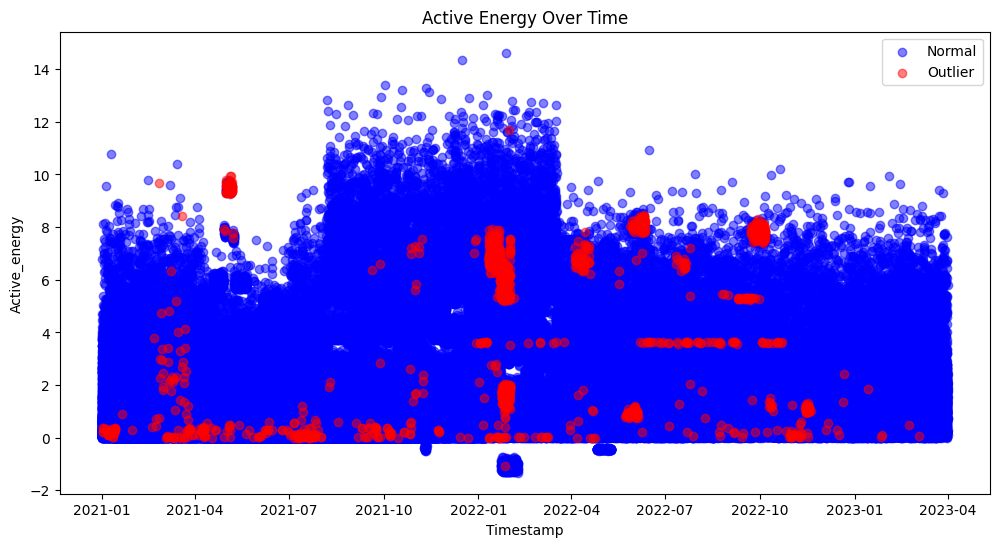

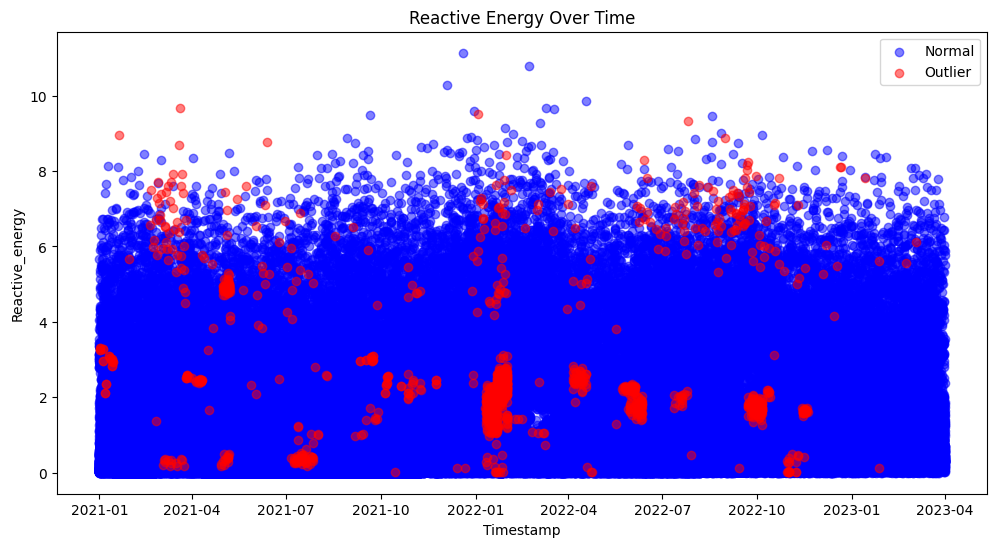

In [52]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])


df_sampled = df.sample(frac=1)


def is_outlier(row):
    if (row['Anomaly_Cluster'] == -1 and
        row['Anomaly_Sector'] == -1 and
        row['Anomaly_Cliente'] == -1 and
        row['Anomaly_Global'] == -1):
        return -1
    else:
        return 1


df_sampled['Outlier_Label'] = df_sampled.apply(is_outlier, axis=1)

# Function to create plots
def plot_data(df, x, y, hue, title):
    plt.figure(figsize=(12, 6))
    # Plot normal observations
    plt.scatter(df[x][df[hue] == 1], df[y][df[hue] == 1], c='blue', label='Normal', alpha=0.5)
    # Plot outliers
    plt.scatter(df[x][df[hue] == -1], df[y][df[hue] == -1], c='red', label='Outlier', alpha=0.5)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel(y)
    plt.legend()
    plt.show()


plot_data(df_sampled, 'Fecha', 'Voltaje_FA', 'Outlier_Label', 'Voltaje FA Over Time')
plot_data(df_sampled, 'Fecha', 'Voltaje_FC', 'Outlier_Label', 'Voltaje FC Over Time')
plot_data(df_sampled, 'Fecha', 'Active_energy', 'Outlier_Label', 'Active Energy Over Time')
plot_data(df_sampled, 'Fecha', 'Reactive_energy', 'Outlier_Label', 'Reactive Energy Over Time')


# 11. Plot of outliers for ClientId=1

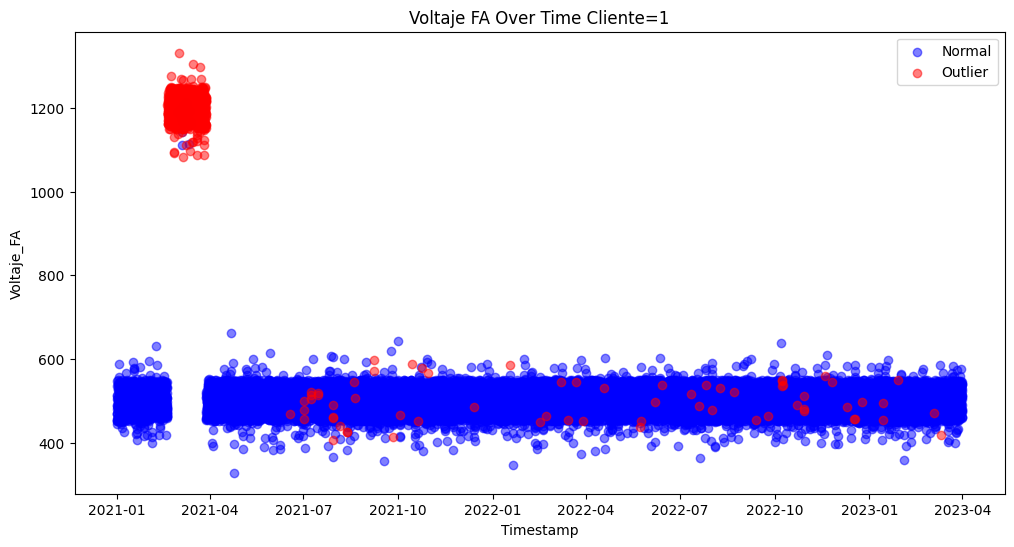

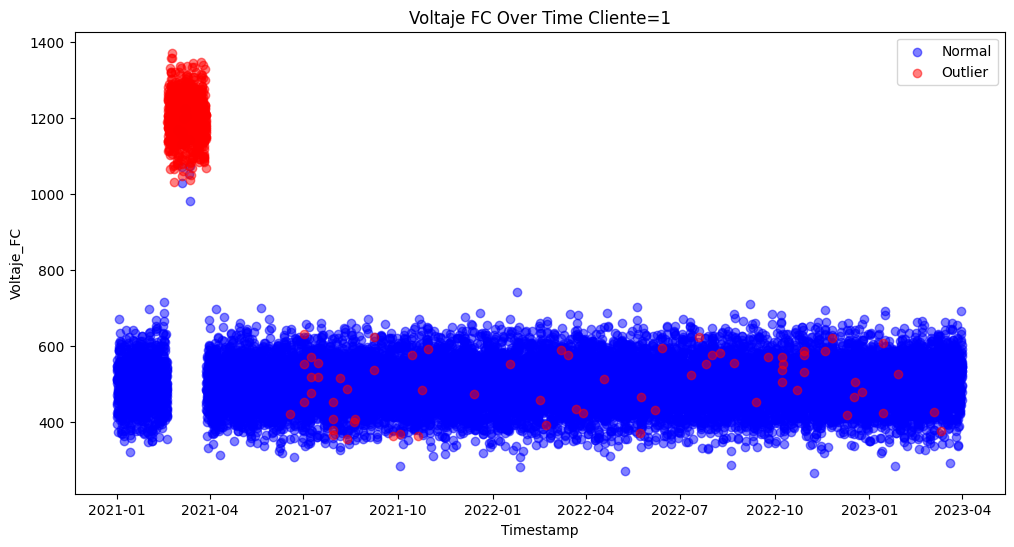

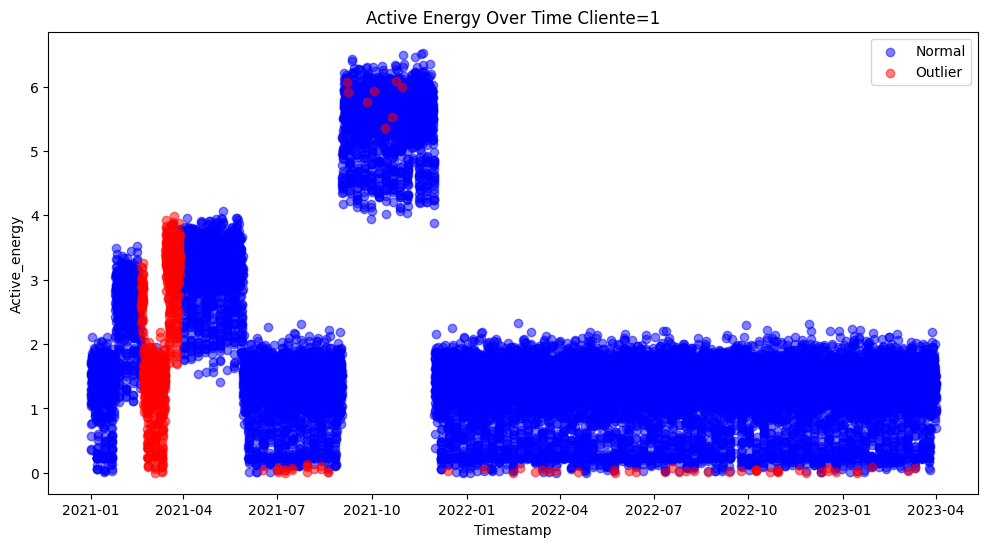

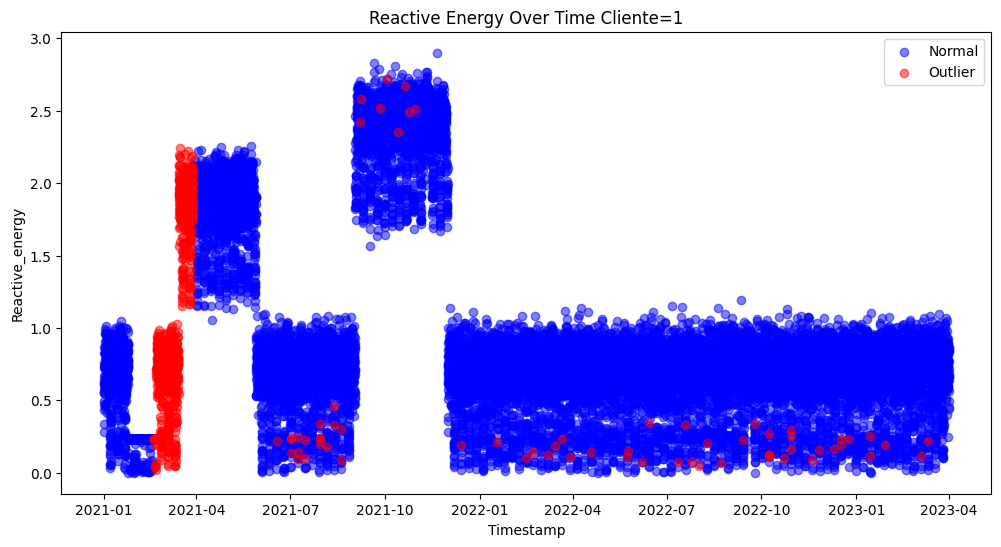

In [53]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
df= df[df['ClienteId']==1]
df['Fecha'] = pd.to_datetime(df['Fecha'])


df_sampled = df.sample(frac=1)


def is_outlier(row):
    if (row['Anomaly_Cliente'] == -1): # and
       # row['Anomaly_Sector'] == -1 and
        #row['Anomaly_Cliente'] == -1 and
        #row['Anomaly_Global'] == -1):
        return -1
    else:
        return 1


df_sampled['Outlier_Label'] = df_sampled.apply(is_outlier, axis=1)

# Function to create plots
def plot_data(df, x, y, hue, title):
    plt.figure(figsize=(12, 6))
    # Plot normal observations
    plt.scatter(df[x][df[hue] == 1], df[y][df[hue] == 1], c='blue', label='Normal', alpha=0.5)
    # Plot outliers
    plt.scatter(df[x][df[hue] == -1], df[y][df[hue] == -1], c='red', label='Outlier', alpha=0.5)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel(y)
    plt.legend()
    plt.show()


plot_data(df_sampled, 'Fecha', 'Voltaje_FA', 'Outlier_Label', 'Voltaje FA Over Time Cliente=1')
plot_data(df_sampled, 'Fecha', 'Voltaje_FC', 'Outlier_Label', 'Voltaje FC Over Time Cliente=1')
plot_data(df_sampled, 'Fecha', 'Active_energy', 'Outlier_Label', 'Active Energy Over Time Cliente=1')
plot_data(df_sampled, 'Fecha', 'Reactive_energy', 'Outlier_Label', 'Reactive Energy Over Time Cliente=1')


# 12. Experiment to determine the behaviour of the outliers for when we have various levels of contamination, searching for observations that are outliers in all contamination factors.

In [20]:
from sklearn.ensemble import IsolationForest

# Range of contamination factors to test.
contamination_factors = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
outliers_detected = {}  
for cont in contamination_factors:
    # Isolation Forest model
    iso_forest = IsolationForest(n_estimators=100, contamination=cont)
    
    # Fit the model
    iso_forest.fit(combined_df[final_features])
    
    # Predict the outliers (-1 for outliers, 1 for inliers)
    predictions = iso_forest.predict(combined_df[final_features])
    
    # Get the indices of outliers
    outlier_indices = np.where(predictions == -1)[0]
    
    # Store the outlier indices in the dictionary
    outliers_detected[cont] = set(outlier_indices)


consistent_outliers = set.intersection(*outliers_detected.values())


consistent_outliers_list = list(consistent_outliers)

# Print the results
print(f"Consistent outliers detected across all contamination factors: {consistent_outliers_list}")








Consistent outliers detected across all contamination factors: [24577, 376833, 368643, 376855, 376862, 368673, 376865, 368676, 368677, 368679, 368682, 24619, 376876, 368685, 376884, 376895, 368708, 368712, 376912, 368723, 368729, 368734, 376927, 368737, 24675, 376934, 417894, 221288, 417897, 368756, 376949, 368762, 434302, 417918, 204941, 417941, 376982, 376983, 417945, 368801, 368808, 368809, 213163, 417964, 377005, 417966, 213167, 368816, 417967, 221362, 368819, 417968, 368827, 417989, 213190, 377030, 377031, 213193, 417991, 368844, 368850, 377047, 368860, 368869, 368873, 368874, 368876, 377072, 377073, 377080, 368890, 377082, 213249, 368898, 377095, 377098, 368909, 418062, 368912, 418064, 418065, 368917, 377110, 368923, 377116, 213278, 368927, 418084, 213287, 368935, 377133, 213296, 368950, 377143, 213305, 368954, 221501, 377152, 368966, 205128, 368973, 368974, 213328, 368976, 368978, 221525, 377174, 418135, 418136, 368990, 368998, 377191, 377204, 369023, 369033, 213386, 377225, 377

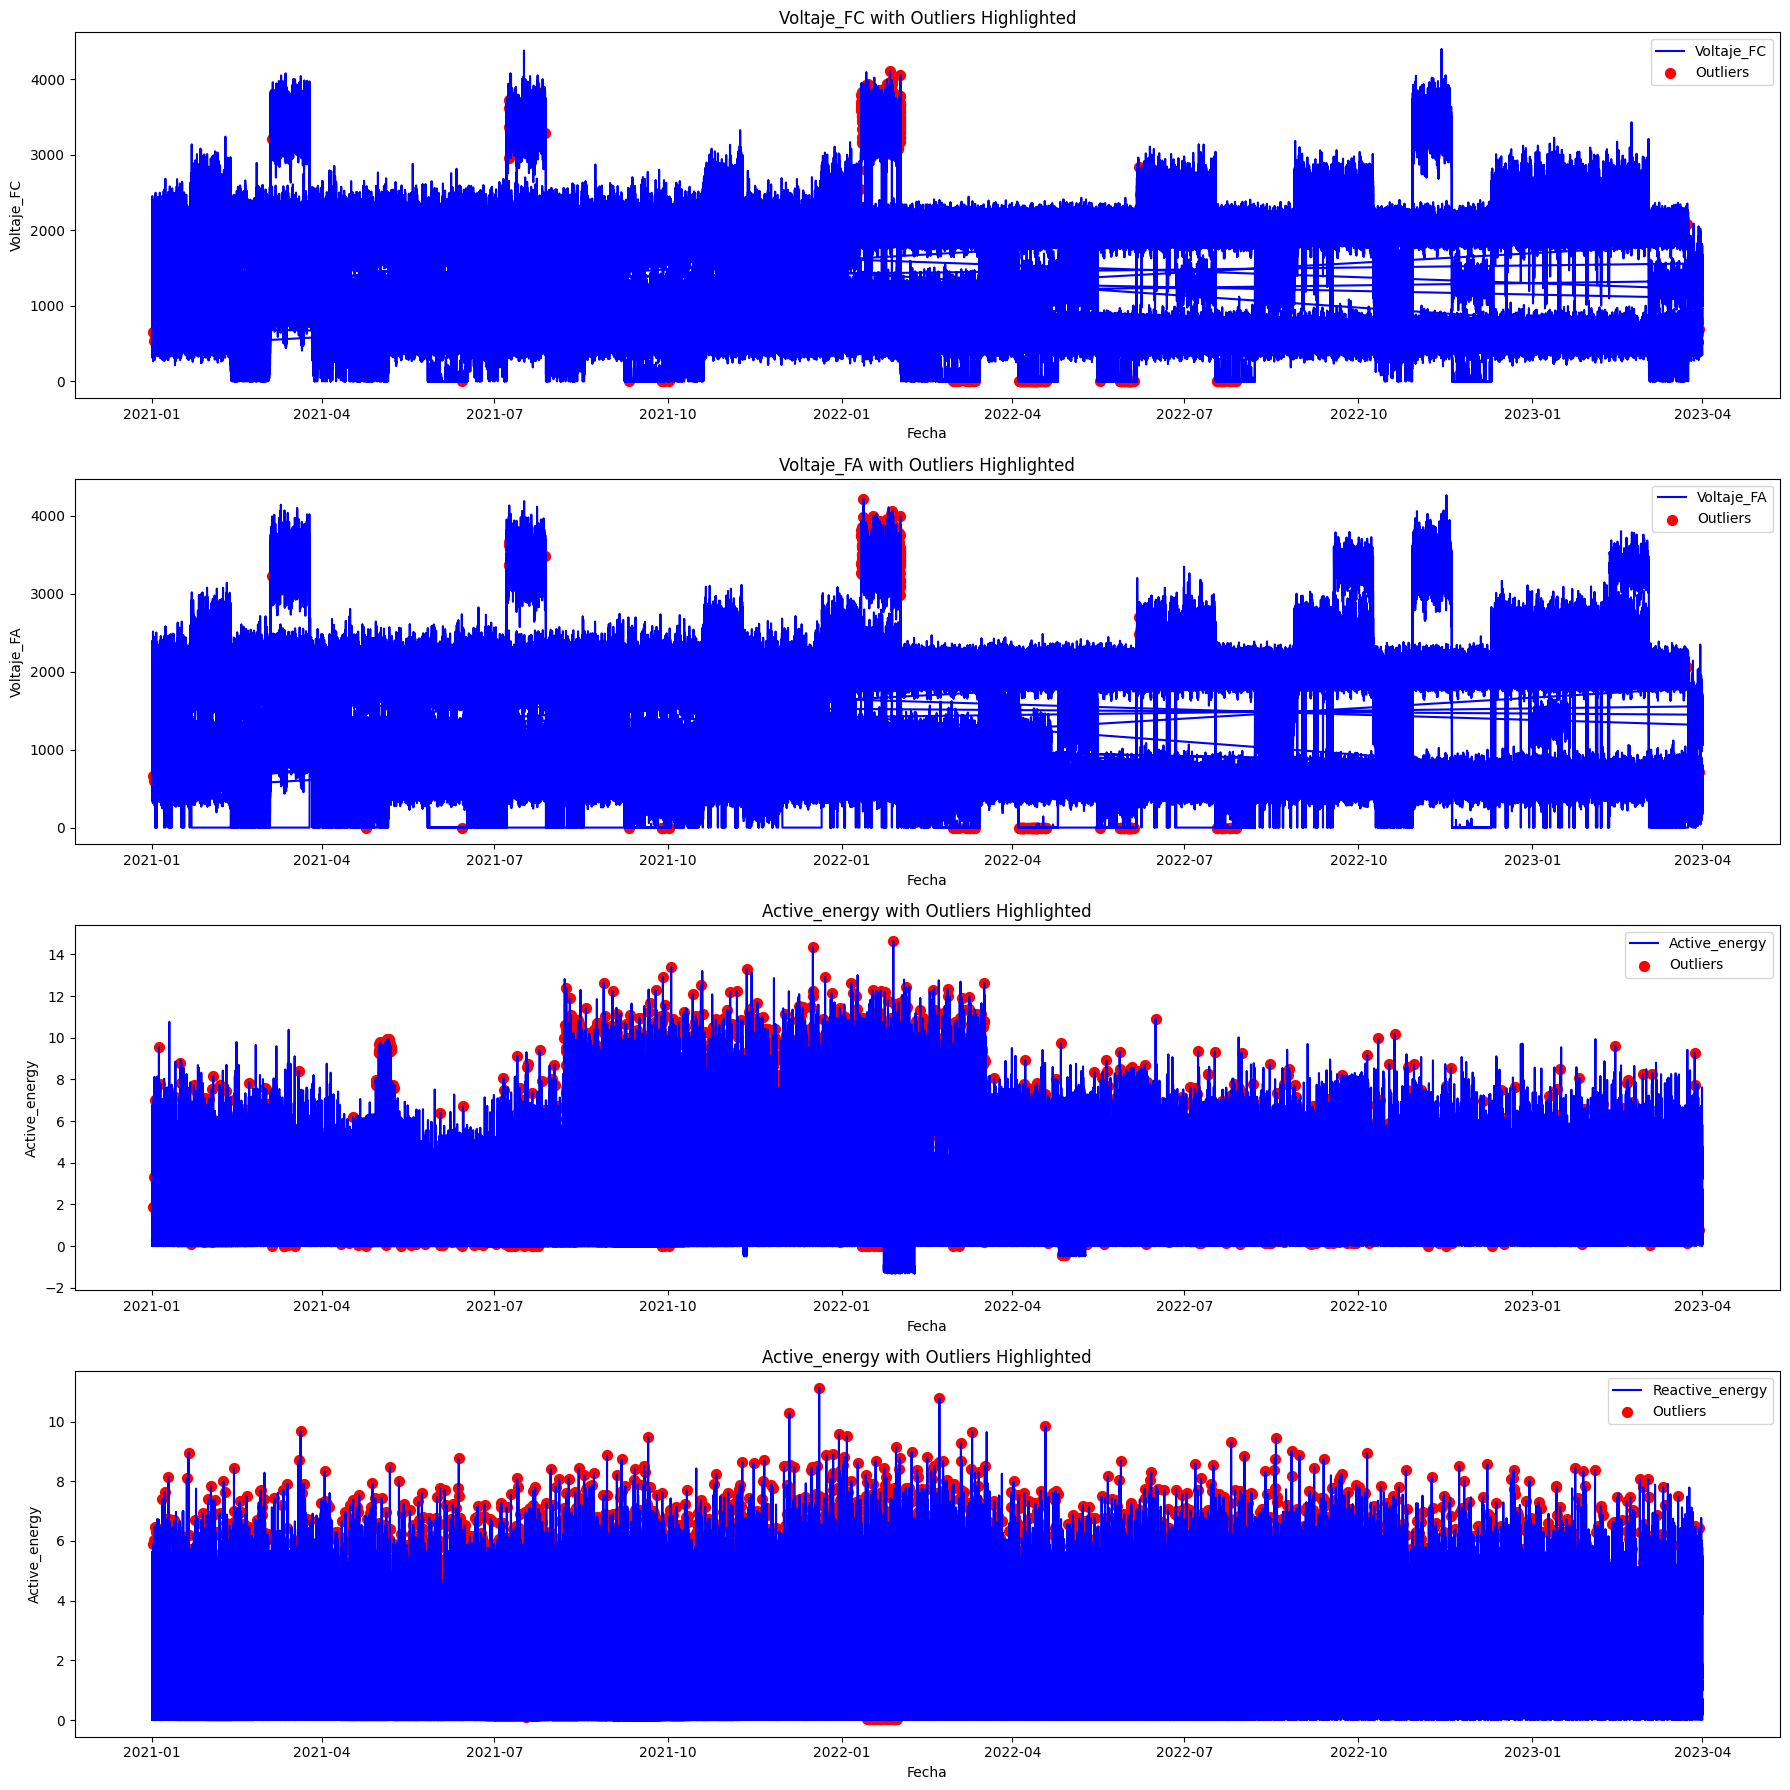

In [21]:
import matplotlib.pyplot as plt
import pandas as pd


#  'consistent_outliers_list' contains the indices of consistent outliers

combined_df['Fecha'] = pd.to_datetime(combined_df['Fecha'])


fig, axs = plt.subplots(4, 1, figsize=(18, 18))  # 2 rows, 1 column

# Plot for Voltaje_FC
axs[0].plot(combined_df['Fecha'], combined_df['Voltaje_FC'], 'b-', label='Voltaje_FC', markersize=5)
axs[0].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Voltaje_FC'], color='red', s=50, label='Outliers')
axs[0].set_title('Voltaje_FC with Outliers Highlighted')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Voltaje_FC')
axs[0].legend()

# Plot for Voltaje_FA
axs[1].plot(combined_df['Fecha'], combined_df['Voltaje_FA'], 'b-', label='Voltaje_FA', markersize=5)
axs[1].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Voltaje_FA'], color='red', s=50, label='Outliers')
axs[1].set_title('Voltaje_FA with Outliers Highlighted')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Voltaje_FA')
axs[1].legend()

# Plot for Voltaje_FA
axs[2].plot(combined_df['Fecha'], combined_df['Active_energy'], 'b-', label='Active_energy', markersize=5)
axs[2].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Active_energy'], color='red', s=50, label='Outliers')
axs[2].set_title('Active_energy with Outliers Highlighted')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('Active_energy')
axs[2].legend()

axs[3].plot(combined_df['Fecha'], combined_df['Reactive_energy'], 'b-', label='Reactive_energy', markersize=5)
axs[3].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Reactive_energy'], color='red', s=50, label='Outliers')
axs[3].set_title('Active_energy with Outliers Highlighted')
axs[3].set_xlabel('Fecha')
axs[3].set_ylabel('Active_energy')
axs[3].legend()

# Adjust the layout of the plot to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
